In [13]:
# import modules
import os
import pandas as pd
import numpy as np
from scipy import stats
import pickle

# import scikit-learn modules
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve, roc_curve

# import visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# save path
cwd = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(cwd, "..", ".."))

# build paths inside the repo
get_data_path = lambda folders, fname: os.path.normpath(
    os.path.join(BASE_DIR, *folders, fname)
)

file_path_training_data = get_data_path(['data', 'output', 'models'], 'training_data.csv')

# load the data for repeated cross-validation
file_RF_model_I_context_repeated = get_data_path(['data', 'output', 'models', 'model_I'], 'RF_model_contextualised_repeated.pickle')
file_RF_model_I_full_repeated = get_data_path(['data', 'output', 'models', 'model_I'], 'RF_model_full_repeated.pickle')

file_RF_model_II_context_repeated = get_data_path(['data', 'output', 'models', 'model_II'], 'RF_model_contextualised_repeated.pickle')
file_RF_model_II_full_repeated = get_data_path(['data', 'output', 'models', 'model_II'], 'RF_model_full_repeated.pickle')

file_RF_model_III_context_repeated = get_data_path(['data', 'output', 'models', 'model_III'], 'RF_model_contextualised_repeated.pickle')
file_RF_model_III_full_repeated = get_data_path(['data', 'output', 'models', 'model_III'], 'RF_model_full_repeated.pickle')

file_RF_model_IV_context = get_data_path(['data', 'output', 'models', 'model_IV'], 'RF_model_contextualised.pickle')
file_RF_model_IV_full = get_data_path(['data', 'output', 'models', 'model_IV'], 'RF_model_full.pickle')

# path for the plots
figure_path_repeated_model1 = get_data_path(['figures'], '3a_model_I_repeated_v2.png')
figure_path_repeated_model2 = get_data_path(['figures'], '3b_model_II_repeated_v2.png')
figure_path_repeated_model3 = get_data_path(['figures'], '3c_model_III_repeated_v2.png')
figure_path_model4 = get_data_path(['figures'], '3d_model_IV_v2.png')


In [15]:
training_df = pd.read_csv(file_path_training_data)

In [16]:
training_df[:3]

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.024593,0.069772,False


In [17]:
feature_columns_1 = ['rMaxExp_A1A2', 'rMinExp_A1A2',
                     'max_ranked_A1A2', 'min_ranked_A1A2',
                     'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 
                     'min_sequence_identity',
                     'prediction_score', 
                     'weighted_PPI_essentiality', 'weighted_PPI_expression',
                     'smallest_BP_GO_essentiality', 'smallest_CC_GO_essentiality',
                     'smallest_BP_GO_expression', 'go_CC_expression'
                     ]

target_column = 'SL_new'

print('num of features:', len(feature_columns_1))

num of features: 16


In [18]:
feature_columns_2 = feature_columns_1 + ['closest', 'WGD', 'family_size',
                                         'cds_length_ratio', 'shared_domains', 'has_pombe_ortholog',
                                         'has_essential_pombe_ortholog', 'has_cerevisiae_ortholog', 'has_essential_cerevisiae_ortholog', 
                                         'conservation_score', 'mean_age', 'either_in_complex', 'mean_complex_essentiality', 'colocalisation',
                                         'interact', 'n_total_ppi', 'fet_ppi_overlap',
                                         'gtex_spearman_corr', 'gtex_min_mean_expr', 'gtex_max_mean_expr']
feature_columns_2.remove('prediction_score')
print('num of features:', len(feature_columns_2))

num of features: 35


In [19]:
print('Num SL:', training_df[training_df[target_column] == True].shape[0], '/', training_df.shape[0])
print('Num non-SL:', training_df[training_df[target_column] == False].shape[0], '/', training_df.shape[0])
print(f'Number of unique gene pairs: {training_df.genepair.nunique()}')
print(f'Number of unique cell lines: {training_df.cell_line.nunique()}')
training_df[:3]

Num SL: 958 / 41244
Num non-SL: 40286 / 41244
Number of unique gene pairs: 4170
Number of unique cell lines: 10


,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.024593,0.069772,False


In [20]:
# Define feature sets
data_1 = training_df[feature_columns_1]
data_2 = training_df[feature_columns_2]
target = training_df[target_column]

In [ ]:
with open(file_RF_model_I_context_repeated, 'rb') as file:
    model_I_context_repeated = pickle.load(file)

with open(file_RF_model_I_full_repeated, 'rb') as file:
    model_I_full_repeated = pickle.load(file)

with open(file_RF_model_II_context_repeated, 'rb') as file:
    model_II_context_repeated = pickle.load(file)

with open(file_RF_model_II_full_repeated, 'rb') as file:
    model_II_full_repeated = pickle.load(file)

with open(file_RF_model_III_context_repeated, 'rb') as file:
    model_III_context_repeated = pickle.load(file)

with open(file_RF_model_III_full_repeated, 'rb') as file:
    model_III_full_repeated = pickle.load(file)

with open(file_RF_model_IV_context, 'rb') as file:
    model_IV_context = pickle.load(file)

with open(file_RF_model_IV_full, 'rb') as file:
    model_IV_full = pickle.load(file)

## Plot ROC AUC & PR AUC Curves

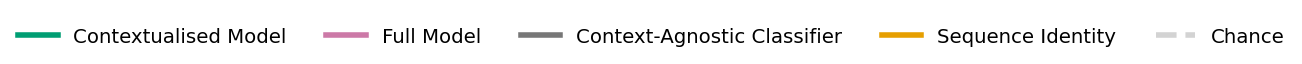

In [101]:
# Define the labels and their styles
legend_labels = [
    "Contextualised Model",
    "Full Model",
    "Context-Agnostic Classifier",
    #"Gene Expression",
    #"Gene Essentiality",
    "Sequence Identity",
    "Chance"
]

legend_styles = [
    {"color": "#009E73", "linestyle": "-"},
    {"color": "#CC79A7", "linestyle": "-"},
    {"color": '#777777', "linestyle": "-"},
   # {"color": '#56B4E9', "linestyle": "-"},
   # {"color": '#009E73', "linestyle": "-"},
    {"color": '#E69F00', "linestyle": "-"},
    {"color": "lightgrey", "linestyle": "--"}
]

plt.figure(figsize=(9, 0.10))

# Create a dummy plot
for style in legend_styles:
    plt.plot([], [], color=style["color"], linestyle=style["linestyle"], linewidth=4)

# Add the legend
plt.legend(
    legend_labels,
    fontsize=14.25,
    loc="upper center",
    ncol=len(legend_labels),  # Arrange in a single row
    frameon=False
)

# Remove axes for a clean legend-only figure
plt.gca().set_axis_off()

# Display or save the legend
#plt.show()
plt.savefig('/Users/narod/Library/CloudStorage/GoogleDrive-narod.kebabci@ucdconnect.ie/My Drive/GitRepos/context_specific_SL_prediction/figures/legend.png', bbox_inches='tight', dpi=600)

In [ ]:
def plot_model_performance(df, data, target, model_context, model_full, file_path):
    sns.set_context('paper')
    f, ax = plt.subplots(1, 2, figsize=(9.5, 4.5))  # ROC and PR side by side

    # --- Contextualized model ---
    roc_display = RocCurveDisplay(
        fpr=model_context['mean_fpr'],
        tpr=model_context['mean_tpr'],
        roc_auc=model_context['mean_auc']
    )
    roc_display.plot(ax=ax[0], color='#009E73', linewidth=1.75, label=f"{round(model_context['mean_auc'], 2):.2f}")

    pr_display = PrecisionRecallDisplay(
        precision=model_context['precision'],
        recall=model_context['recall'],
        average_precision=model_context['mean_aps']
    )
    pr_display.plot(ax=ax[1], color='#009E73', linewidth=1.75, label=f"{round(model_context['mean_aps'], 2):.2f}")

    # --- full model ---
    roc_display = RocCurveDisplay(
        fpr=model_full['mean_fpr'],
        tpr=model_full['mean_tpr'],
        roc_auc=model_full['mean_auc']
    )
    roc_display.plot(ax=ax[0], alpha=0.8, color='#CC79A7', linewidth=1.75, label=f"{round(model_full['mean_auc'], 2):.2f}")

    pr_display = PrecisionRecallDisplay(
        precision=model_full['precision'],
        recall=model_full['recall'],
        average_precision=model_full['mean_aps']
    )
    pr_display.plot(ax=ax[1], alpha=0.8, color='#CC79A7', linewidth=1.75, label=f"{round(model_full['mean_aps'], 2):.2f}")

    # --- Additional classifier-like metrics ---
    metrics = ['prediction_score', 'min_sequence_identity']
    colors = ['#777777', '#E69F00']
    auc_labels = ['pred_auc', 'seq_auc']
    ap_labels = ['pred_ap', 'seq_ap']

    for metric, color, auc_label, ap_label in zip(metrics, colors, auc_labels, ap_labels):
        score = data[metric] if metric != 'min_ranked_A1A2' else -data[metric]
        mask = ~score.isna()
        y_true = target[mask]
        y_score = score[mask]

        if len(np.unique(y_true)) < 2:
            print(f"Skipping {metric}: not enough label variation after NaN removal.")
            continue

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = model_context[auc_label]
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        roc_display.plot(ax=ax[0], color=color, linewidth=1.75, label=f"{round(roc_auc, 2):.2f}")

        # PR Curve
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        pr_auc = model_context[ap_label]
        pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc)
        pr_display.plot(ax=ax[1], color=color, linewidth=1.75, label=f"{round(pr_auc, 2):.2f}")

    # --- ROC chance line ---
    ax[0].plot([0, 1], [0, 1], color="lightgrey", linestyle="--", label="0.50")
    ax[0].set_xlim([-0.025, 1.025])
    ax[0].set_ylim([-0.025, 1.025])
    ax[0].spines.top.set(visible=False)
    ax[0].spines.right.set(visible=False)
    ax[0].tick_params(axis='both', which='major', labelsize=11)
    ax[0].set_xlabel('False Positive Rate', fontsize=12)
    ax[0].set_ylabel('True Positive Rate', fontsize=12)
    ax[0].legend(loc='lower right', fontsize=12, bbox_to_anchor=(1.02, 0))

    # --- PR baseline ---
    no_skill = round(sum(df['SL_new']) / len(df['SL_new']), 3)
    ax[1].plot([0, 1], [no_skill, no_skill], linestyle='--', color='lightgrey', label=f"{round(no_skill, 2):.2f}")
    ax[1].set_xlim([-0.025, 1.025])
    ax[1].set_ylim([-0.025, 1.025])
    ax[1].spines.top.set(visible=False)
    ax[1].spines.right.set(visible=False)
    ax[1].set_xlabel('Recall', fontsize=12)
    ax[1].set_ylabel('Precision', fontsize=12)
    ax[1].tick_params(axis='both', which='major', labelsize=11)
    ax[1].legend(loc='upper right', fontsize=12)

    plt.tight_layout(h_pad=0.7)
    plt.savefig(file_path, bbox_inches='tight', dpi=400)
    plt.close(f)


In [ ]:
plot_model_performance(training_df, data_1, target, model_I_context_repeated, model_I_full_repeated, figure_path_repeated_model1)
plot_model_performance(training_df, data_1, target, model_II_context_repeated, model_II_full_repeated, figure_path_repeated_model2)
plot_model_performance(training_df, data_1, target, model_III_context_repeated, model_III_full_repeated, figure_path_repeated_model3)
plot_model_performance(training_df, data_1, target, model_IV_context, model_IV_full, figure_path_model4)

## Two sample t test 

ROC AUC from the two different models are identical == null hypothesis

if pval < 0.05 reject the null hypothesis, if pval > 0.05 fail to reject the null hypothesis

### T-test Contextualized Model

In [ ]:
roc_auc_values = {
    'Strategy I': model_I_context_repeated['aucs'],
    'Strategy II': model_II_context_repeated['aucs'],
    'Strategy III': model_III_context_repeated['aucs'],
    'Strategy IV': model_IV_context['aucs']
}

roc_auc_df = pd.DataFrame(roc_auc_values).melt(var_name='Strategy', value_name='ROC AUC')
roc_auc_df['label'] = roc_auc_df['Strategy'].apply(lambda x: 'First' if x == 'Strategy I' else 'Others')

# Performing t-tests between Model I and other models
t_tests_results = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

for strategy in ['Strategy II', 'Strategy III', 'Strategy IV']:
    t_stat, p_value = stats.ttest_ind(roc_auc_values['Strategy I'], roc_auc_values[strategy])
    t_tests_results['Comparison'].append(f'Strategy I vs {strategy}')
    t_tests_results['t_statistic'].append(t_stat)
    t_tests_results['p_value'].append(p_value)

t_tests_df = pd.DataFrame(t_tests_results)

# Adding significance column to the t_tests_df based on p-value threshold (e.g., p < 0.05)
t_tests_df['Significance'] = t_tests_df['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

display(t_tests_df)

t_tests_results_v2 = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

# Define pairs of models for pairwise comparisons
strategy_pairs = [('Strategy II', 'Strategy I'), ('Strategy III', 'Strategy II'), 
               ('Strategy IV', 'Strategy III'), ('Strategy IV', 'Strategy II')]

# Perform t-tests for each pair
for model_a, model_b in strategy_pairs:
    t_stat, p_value = stats.ttest_ind(roc_auc_values[model_a], roc_auc_values[model_b])
    t_tests_results_v2['Comparison'].append(f'{model_a} vs {model_b}')
    t_tests_results_v2['t_statistic'].append(t_stat)
    t_tests_results_v2['p_value'].append(p_value)

t_tests_df_v2 = pd.DataFrame(t_tests_results_v2)

# Adding significance column to the t_tests_df_v2 based on p-value threshold (e.g., p < 0.05)
t_tests_df_v2['Significance'] = t_tests_df_v2['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

display(t_tests_df_v2)

,Comparison,t_statistic,p_value,Significance
0,Strategy I vs Strategy II,4.109346,8.243001e-05,Significantly different
1,Strategy I vs Strategy III,6.518706,3.092425e-09,Significantly different
2,Strategy I vs Strategy IV,7.951597,3.217370e-12,Significantly different


,Comparison,t_statistic,p_value,Significance
0,Strategy II vs Strategy I,-4.109346,0.000082,Significantly different
1,Strategy III vs Strategy II,0.719757,0.473388,Statistically similar
2,Strategy IV vs Strategy III,-4.864261,0.000004,Significantly different
3,Strategy IV vs Strategy II,-3.453307,0.000819,Significantly different


In [92]:
# Define the function for drawing significance lines on a separate axis
def draw_signif_line(ax, x0, x1, y, pval, hd=5):
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    #ax.plot([x0, x0, x1, x1], [y + h * .5, y + 2 * h, y + 2 * h, y + h * .5], lw=1, c='#666')
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=1, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=9)

In [ ]:
# Set up the figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(4.12, 4), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Draw significance lines on the top subplot
draw_signif_line(ax[0], 0, 1, 0.055, t_tests_df.loc[0, 'p_value'])  # Between model 1 and model 2
draw_signif_line(ax[0], 0, 2, 0.2, t_tests_df.loc[1, 'p_value'])  # Between model 1 and model 3
draw_signif_line(ax[0], 0, 3, 0.32, t_tests_df.loc[2, 'p_value'])  # Between model 1 and model 4

# Customize the top subplot for significance lines
ax[0].axis('off')
ax[0].set_ylim([0, 0.4])  # Adjust based on space needed for significance lines

# Main bar plot in the bottom subplot
color_dict = {'First': '#D55E00', 'Others': '#009E73'}
#sns.barplot(data=roc_auc_df, x='Model', y='ROC AUC', hue='label', errorbar="sd", dodge=False, ax=ax[1], palette=color_dict)
sns.boxplot(x='Strategy', y='ROC AUC', hue='label', data=roc_auc_df, ax=ax[1], linewidth=0.8, saturation=0.8, 
            showfliers=False, showmeans=False, palette=color_dict,
            medianprops={'color':'black', 'linewidth':0.8},
            boxprops={'edgecolor':'black', 'alpha':0.75},)
sns.swarmplot(data=roc_auc_df, x='Strategy', y='ROC AUC', color='black', size=2, dodge=True, ax=ax[1])#, alpha=0.7)
# Customize the main plot appearance
ax[1].spines.top.set(visible=False)
ax[1].spines.right.set(visible=False)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_xlabel('')
ax[1].set_ylabel('ROC AUC', fontsize=11)
ax[1].set_ylim([0.7, 1])
ax[1].legend().remove()

plt.tight_layout(h_pad=0)  # Reduce vertical space between subplots

#boxplot_path = get_data_path(['figures', 'supp_figures'], 'boxplot_roc_aucs.png')
#plt.savefig(boxplot_path, bbox_inches='tight', dpi=350)

plt.show()

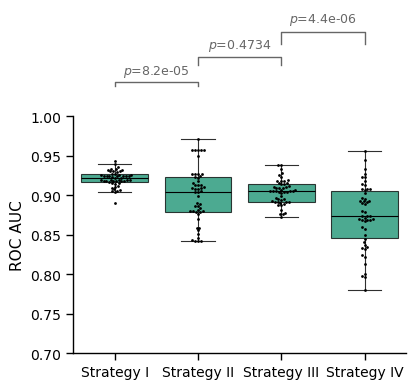

In [93]:
# Set up the figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(4.25, 4), gridspec_kw={'height_ratios': [1.5, 3.5]}, sharex=True)

# Draw significance lines on the top subplot
draw_signif_line(ax[0], 0, 1, 0.082, t_tests_df_v2.loc[0, 'p_value'])  # Between model 2 and model 1
draw_signif_line(ax[0], 1, 2, 0.15, t_tests_df_v2.loc[1, 'p_value'])  # Between model 3 and model 2
draw_signif_line(ax[0], 2, 3, 0.22, t_tests_df_v2.loc[2, 'p_value'])  # Between model 4 and model 3
#draw_signif_line(ax[0], 2, 3, 0.32, t_tests_df_v2.loc[3, 'p_value'])  # Between model 4 and model 2

# Customize the top subplot for significance lines
ax[0].axis('off')
ax[0].set_ylim([0, 0.4])  # Adjust based on space needed for significance lines

# Main bar plot in the bottom subplot
#color_dict = {'First': '#D55E00', 'Others': '#009E73'}
#sns.barplot(data=roc_auc_df, x='Model', y='ROC AUC', hue='label', errorbar="sd", dodge=False, ax=ax[1], palette=color_dict)
sns.boxplot(x='Strategy', y='ROC AUC', data=roc_auc_df, ax=ax[1], linewidth=0.8, saturation=0.8, 
            showfliers=False, showmeans=False, color='#009E73',
            medianprops={'color':'black', 'linewidth':0.8},
            boxprops={'edgecolor':'black', 'alpha':0.75},)
sns.swarmplot(data=roc_auc_df, x='Strategy', y='ROC AUC', color='black', size=2, dodge=True, ax=ax[1])#, alpha=0.7)
# Customize the main plot appearance
ax[1].spines.top.set(visible=False)
ax[1].spines.right.set(visible=False)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_xlabel('')
ax[1].set_ylabel('ROC AUC', fontsize=11)
ax[1].set_ylim([0.7, 1])
#ax[1].legend().remove()

plt.tight_layout(h_pad=0)  # Reduce vertical space between subplots

boxplot_path = get_data_path(['figures', 'supp_figures'], 'boxplot_contextualized_model_roc_aucs_v3.png')
plt.savefig(boxplot_path, bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
pr_auc_values = {
    'Strategy I': model_I_context_repeated['aps'],
    'Strategy II': model_II_context_repeated['aps'],
    'Strategy III': model_III_context_repeated['aps'],
    'Strategy IV': model_IV_context['aps']
}

pr_auc_df = pd.DataFrame(pr_auc_values).melt(var_name='Strategy', value_name='PR AUC')
pr_auc_df['label'] = pr_auc_df['Strategy'].apply(lambda x: 'First' if x == 'Strategy I' else 'Others')
# Performing t-tests between Strategy I and other strategies
t_tests_results_pr = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

for strategy in ['Strategy II', 'Strategy III', 'Strategy IV']:
    t_stat_pr, p_value_pr = stats.ttest_ind(pr_auc_values['Strategy I'], pr_auc_values[strategy])
    t_tests_results_pr['Comparison'].append(f'Strategy I vs {strategy}')
    t_tests_results_pr['t_statistic'].append(t_stat_pr)
    t_tests_results_pr['p_value'].append(p_value_pr)

t_tests_df_pr = pd.DataFrame(t_tests_results_pr)

# Adding significance column to the t_tests_df based on p-value threshold (e.g., p < 0.05)
t_tests_df_pr['Significance'] = t_tests_df_pr['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

# Display the results
display(t_tests_df_pr)

# Performing t-tests between Model I and other models
t_tests_results_pr_v2 = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

# Define pairs of models for pairwise comparisons
model_pairs = [('Strategy I', 'Strategy II'), ('Strategy II', 'Strategy III'), 
               ('Strategy II', 'Strategy IV'), ('Strategy III', 'Strategy IV')]

# Perform t-tests for each pair
for model_a, model_b in model_pairs:
    t_stat_pr, p_value_pr = stats.ttest_ind(pr_auc_values[model_a], pr_auc_values[model_b])
    t_tests_results_pr_v2['Comparison'].append(f'{model_a} vs {model_b}')
    t_tests_results_pr_v2['t_statistic'].append(t_stat_pr)
    t_tests_results_pr_v2['p_value'].append(p_value_pr)

# Create DataFrame to store results
t_tests_df_pr_v2 = pd.DataFrame(t_tests_results_pr_v2)

# Add significance column based on p-value threshold (e.g., p < 0.05)
t_tests_df_pr_v2['Significance'] = t_tests_df_pr_v2['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

# Display the results
display(t_tests_df_pr_v2)


,Comparison,t_statistic,p_value,Significance
0,Strategy I vs Strategy II,6.992807,3.325585e-10,Significantly different
1,Strategy I vs Strategy III,5.666664,1.463325e-07,Significantly different
2,Strategy I vs Strategy IV,10.899570,1.365965e-18,Significantly different


,Comparison,t_statistic,p_value,Significance
0,Strategy I vs Strategy II,6.992807,3.325585e-10,Significantly different
1,Strategy II vs Strategy III,-1.972000,5.142842e-02,Statistically similar
2,Strategy II vs Strategy IV,4.444741,2.319644e-05,Significantly different
3,Strategy III vs Strategy IV,6.467993,3.913076e-09,Significantly different


In [95]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=1, c='#666')
    ax.text((x0 + x1) * .5, y + 2.2 * h, text, ha='center', va='bottom', color='#666', fontsize=9)

In [ ]:
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(4, 4))
color_dict = {'First': '#D55E00', 'Others': '#009E73'}
#sns.barplot(data=pr_auc_df, x='Model', y='PR AUC', hue='label', errorbar="sd", dodge=False, ax=ax, palette=color_dict)
sns.boxplot(x='Model', y='PR AUC', hue='label', data=pr_auc_df, ax=ax, linewidth=0.8, saturation=0.8, 
            showfliers=False, showmeans=False, palette=color_dict,
            medianprops={'color':'black', 'linewidth':0.8},
            boxprops={'edgecolor':'black', 'alpha':0.75},)
sns.swarmplot(data=pr_auc_df, x='Model', y='PR AUC', color='black', size=2, dodge=True, ax=ax)#, alpha=0.7)

# Add significance lines
draw_signif_line(ax, 0, 1, 0.41, t_tests_df_pr.loc[0, 'p_value'])
draw_signif_line(ax, 0, 2, 0.47, t_tests_df_pr.loc[1, 'p_value'])  # Between model 1 and model 3
draw_signif_line(ax, 0, 3, 0.54, t_tests_df_pr.loc[2, 'p_value'])  # Between model 1 and model 4

ax.spines.top.set(visible=False)
ax.spines.right.set(visible=False)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel('')
ax.set_ylabel('Average Precision', fontsize=11)
ax.set_ylim([0, 0.6])
ax.legend().remove()
#ax[0].legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.02, 0))

boxplot_path_v2 = get_data_path(['figures', 'supp_figures'], 'boxplot_pr_aucs.png')
plt.savefig(boxplot_path_v2, bbox_inches='tight', dpi=350)

#plt.show()

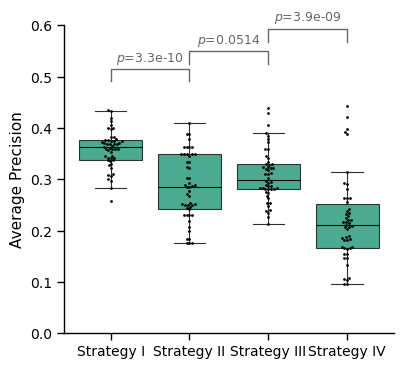

In [96]:
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(4.25, 4))

sns.boxplot(x='Strategy', y='PR AUC', data=pr_auc_df, ax=ax, linewidth=0.8, saturation=0.8, 
            showfliers=False, showmeans=False, color='#009E73',
            medianprops={'color':'black', 'linewidth':0.8},
            boxprops={'edgecolor':'black', 'alpha':0.75},)
sns.swarmplot(data=pr_auc_df, x='Strategy', y='PR AUC', color='black', size=2, dodge=True, ax=ax)#, alpha=0.7)

# Add significance lines
draw_signif_line(ax, 0, 1, 0.468, t_tests_df_pr_v2.loc[0, 'p_value']) # Between model 1 and model 2
draw_signif_line(ax, 1, 2, 0.50, t_tests_df_pr_v2.loc[1, 'p_value'])  # Between model 2 and model 3
draw_signif_line(ax, 2, 3, 0.54, t_tests_df_pr_v2.loc[3, 'p_value'])  # Between model 3 and model 4

ax.spines.top.set(visible=False)
ax.spines.right.set(visible=False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('')
ax.set_ylabel('Average Precision', fontsize=11)
ax.set_ylim([0, 0.6])
#ax.legend().remove()
#ax[0].legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.02, 0))

boxplot_path_v2 = get_data_path(['figures', 'supp_figures'], 'boxplot_contextualized_model_pr_aucs_v3.png')
plt.savefig(boxplot_path_v2, bbox_inches='tight', dpi=600)

plt.show()

### T-test for Full Model

In [ ]:
roc_auc_values = {
    'Strategy I': model_I_full_repeated['aucs'],
    'Strategy II': model_II_full_repeated['aucs'],
    'Strategy III': model_III_full_repeated['aucs'],
    'Strategy IV': model_IV_full['aucs']
}

roc_auc_df = pd.DataFrame(roc_auc_values).melt(var_name='Strategy', value_name='ROC AUC')
roc_auc_df['label'] = roc_auc_df['Strategy'].apply(lambda x: 'First' if x == 'Strategy I' else 'Others')

# Performing t-tests between Model I and other models
t_tests_results = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

for strategy in ['Strategy II', 'Strategy III', 'Strategy IV']:
    t_stat, p_value = stats.ttest_ind(roc_auc_values['Strategy I'], roc_auc_values[strategy])
    t_tests_results['Comparison'].append(f'Strategy I vs {strategy}')
    t_tests_results['t_statistic'].append(t_stat)
    t_tests_results['p_value'].append(p_value)

t_tests_df = pd.DataFrame(t_tests_results)

# Adding significance column to the t_tests_df based on p-value threshold (e.g., p < 0.05)
t_tests_df['Significance'] = t_tests_df['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

display(t_tests_df)

t_tests_results_v2 = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

# Define pairs of models for pairwise comparisons
strategy_pairs = [('Strategy II', 'Strategy I'), ('Strategy III', 'Strategy II'), 
               ('Strategy IV', 'Strategy III'), ('Strategy IV', 'Strategy II')]

# Perform t-tests for each pair
for model_a, model_b in strategy_pairs:
    t_stat, p_value = stats.ttest_ind(roc_auc_values[model_a], roc_auc_values[model_b])
    t_tests_results_v2['Comparison'].append(f'{model_a} vs {model_b}')
    t_tests_results_v2['t_statistic'].append(t_stat)
    t_tests_results_v2['p_value'].append(p_value)

t_tests_df_v2 = pd.DataFrame(t_tests_results_v2)

# Adding significance column to the t_tests_df_v2 based on p-value threshold (e.g., p < 0.05)
t_tests_df_v2['Significance'] = t_tests_df_v2['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

display(t_tests_df_v2)

,Comparison,t_statistic,p_value,Significance
0,Strategy I vs Strategy II,3.150913,2.159010e-03,Significantly different
1,Strategy I vs Strategy III,10.085907,7.878869e-17,Significantly different
2,Strategy I vs Strategy IV,8.259302,7.074214e-13,Significantly different


,Comparison,t_statistic,p_value,Significance
0,Strategy II vs Strategy I,-3.150913,0.002159,Significantly different
1,Strategy III vs Strategy II,-1.810912,0.073218,Statistically similar
2,Strategy IV vs Strategy III,-4.125100,0.000078,Significantly different
3,Strategy IV vs Strategy II,-4.658059,0.000010,Significantly different


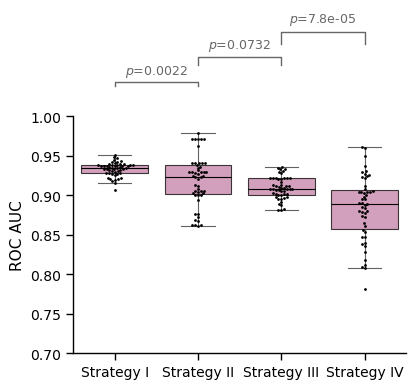

In [98]:
# Define the function for drawing significance lines on a separate axis
def draw_signif_line(ax, x0, x1, y, pval, hd=5):
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=1, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=9)

# Set up the figure with two subplots
fig, ax = plt.subplots(2, 1, figsize=(4.25, 4), gridspec_kw={'height_ratios': [1.5, 3.5]}, sharex=True)

# Draw significance lines on the top subplot
draw_signif_line(ax[0], 0, 1, 0.082, t_tests_df_v2.loc[0, 'p_value'])  # Between model 2 and model 1
draw_signif_line(ax[0], 1, 2, 0.15, t_tests_df_v2.loc[1, 'p_value'])  # Between model 3 and model 2
draw_signif_line(ax[0], 2, 3, 0.22, t_tests_df_v2.loc[2, 'p_value'])  # Between model 4 and model 3
#draw_signif_line(ax[0], 2, 3, 0.32, t_tests_df_v2.loc[3, 'p_value'])  # Between model 4 and model 2

# Customize the top subplot for significance lines
ax[0].axis('off')
ax[0].set_ylim([0, 0.4])  # Adjust based on space needed for significance lines

# Main bar plot in the bottom subplot
#color_dict = {'First': '#D55E00', 'Others': '#009E73'}
#sns.barplot(data=roc_auc_df, x='Model', y='ROC AUC', hue='label', errorbar="sd", dodge=False, ax=ax[1], palette=color_dict)
sns.boxplot(x='Strategy', y='ROC AUC', data=roc_auc_df, ax=ax[1], linewidth=0.8, saturation=0.8, 
            showfliers=False, showmeans=False, color='#CC79A7',
            medianprops={'color':'black', 'linewidth':0.8},
            boxprops={'edgecolor':'black', 'alpha':0.75},)
sns.swarmplot(data=roc_auc_df, x='Strategy', y='ROC AUC', color='black', size=2, dodge=True, ax=ax[1])#, alpha=0.7)
# Customize the main plot appearance
ax[1].spines.top.set(visible=False)
ax[1].spines.right.set(visible=False)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].set_xlabel('')
ax[1].set_ylabel('ROC AUC', fontsize=11)
ax[1].set_ylim([0.7, 1])
#ax[1].legend().remove()

plt.tight_layout(h_pad=0)  # Reduce vertical space between subplots

boxplot_path = get_data_path(['figures', 'supp_figures'], 'boxplot_full_model_roc_aucs_v3.png')
plt.savefig(boxplot_path, bbox_inches='tight', dpi=600)

plt.show()

In [ ]:
pr_auc_values = {
    'Strategy I': model_I_full_repeated['aps'],
    'Strategy II': model_II_full_repeated['aps'],
    'Strategy III': model_III_full_repeated['aps'],
    'Strategy IV': model_IV_full['aps']
}

pr_auc_df = pd.DataFrame(pr_auc_values).melt(var_name='Strategy', value_name='PR AUC')
pr_auc_df['label'] = pr_auc_df['Strategy'].apply(lambda x: 'First' if x == 'Strategy I' else 'Others')
# Performing t-tests between Strategy I and other strategies
t_tests_results_pr = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

for strategy in ['Strategy II', 'Strategy III', 'Strategy IV']:
    t_stat_pr, p_value_pr = stats.ttest_ind(pr_auc_values['Strategy I'], pr_auc_values[strategy])
    t_tests_results_pr['Comparison'].append(f'Strategy I vs {strategy}')
    t_tests_results_pr['t_statistic'].append(t_stat_pr)
    t_tests_results_pr['p_value'].append(p_value_pr)

t_tests_df_pr = pd.DataFrame(t_tests_results_pr)

# Adding significance column to the t_tests_df based on p-value threshold (e.g., p < 0.05)
t_tests_df_pr['Significance'] = t_tests_df_pr['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

# Display the results
display(t_tests_df_pr)

# Performing t-tests between Model I and other models
t_tests_results_pr_v2 = {
    'Comparison': [],
    't_statistic': [],
    'p_value': []
}

# Define pairs of models for pairwise comparisons
model_pairs = [('Strategy I', 'Strategy II'), ('Strategy II', 'Strategy III'), 
               ('Strategy II', 'Strategy IV'), ('Strategy III', 'Strategy IV')]

# Perform t-tests for each pair
for model_a, model_b in model_pairs:
    t_stat_pr, p_value_pr = stats.ttest_ind(pr_auc_values[model_a], pr_auc_values[model_b])
    t_tests_results_pr_v2['Comparison'].append(f'{model_a} vs {model_b}')
    t_tests_results_pr_v2['t_statistic'].append(t_stat_pr)
    t_tests_results_pr_v2['p_value'].append(p_value_pr)

# Create DataFrame to store results
t_tests_df_pr_v2 = pd.DataFrame(t_tests_results_pr_v2)

# Add significance column based on p-value threshold (e.g., p < 0.05)
t_tests_df_pr_v2['Significance'] = t_tests_df_pr_v2['p_value'].apply(lambda p: 'Significantly different' if p < 0.05 else 'Statistically similar')

# Display the results
display(t_tests_df_pr_v2)


,Comparison,t_statistic,p_value,Significance
0,Strategy I vs Strategy II,5.804671,7.956052e-08,Significantly different
1,Strategy I vs Strategy III,9.545325,1.174732e-15,Significantly different
2,Strategy I vs Strategy IV,14.524694,3.552022e-26,Significantly different


,Comparison,t_statistic,p_value,Significance
0,Strategy I vs Strategy II,5.804671,7.956052e-08,Significantly different
1,Strategy II vs Strategy III,0.977185,3.308838e-01,Statistically similar
2,Strategy II vs Strategy IV,7.350853,5.985975e-11,Significantly different
3,Strategy III vs Strategy IV,7.730424,9.494211e-12,Significantly different


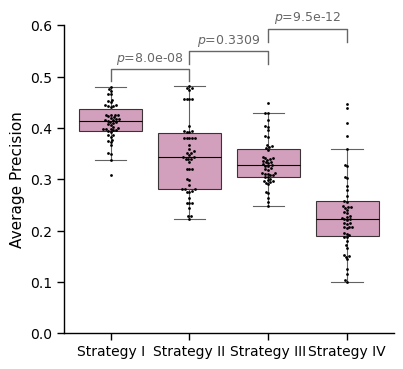

In [100]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=1, c='#666')
    ax.text((x0 + x1) * .5, y + 2.2 * h, text, ha='center', va='bottom', color='#666', fontsize=9)

sns.set_context('paper')
fig, ax = plt.subplots(figsize=(4.25, 4))

sns.boxplot(x='Strategy', y='PR AUC', data=pr_auc_df, ax=ax, linewidth=0.8, saturation=0.8, 
            showfliers=False, showmeans=False, color='#CC79A7',
            medianprops={'color':'black', 'linewidth':0.8},
            boxprops={'edgecolor':'black', 'alpha':0.75},)
sns.swarmplot(data=pr_auc_df, x='Strategy', y='PR AUC', color='black', size=2, dodge=True, ax=ax)#, alpha=0.7)

# Add significance lines
draw_signif_line(ax, 0, 1, 0.468, t_tests_df_pr_v2.loc[0, 'p_value']) # Between model 1 and model 2
draw_signif_line(ax, 1, 2, 0.50, t_tests_df_pr_v2.loc[1, 'p_value'])  # Between model 2 and model 3
draw_signif_line(ax, 2, 3, 0.54, t_tests_df_pr_v2.loc[3, 'p_value'])  # Between model 3 and model 4

ax.spines.top.set(visible=False)
ax.spines.right.set(visible=False)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel('')
ax.set_ylabel('Average Precision', fontsize=11)
ax.set_ylim([0, 0.6])
#ax.legend().remove()
#ax[0].legend(loc='lower right', fontsize=9, bbox_to_anchor=(1.02, 0))

boxplot_path_v2 = get_data_path(['figures', 'supp_figures'], 'boxplot_full_model_pr_aucs_v3.png')
plt.savefig(boxplot_path_v2, bbox_inches='tight', dpi=600)

plt.show()